# DestinE Platform CacheB data access

## Prerequisites
### DESP Credentials

You need to have an account on the [Destination Earth Platform](https://auth.destine.eu/realms/desp/account)

## Access the Data
With a DESP account you can access the dataset in the CacheB cache with Xarray / Zarr.

Here below the list of available datasets, they are all reachable via a dedicated URL. In the following example we will work only with the Climate DT high resolution surface with hourly resolution, on atmosphere variables.

In [1]:
datasets = [
    "https://cacheb.dcms.destine.eu/d1-climate-dt/ScenarioMIP-SSP3-7.0-IFS-NEMO-0001-high-sfc-v0.zarr",
    "https://cacheb.dcms.destine.eu/d1-climate-dt/ScenarioMIP-SSP3-7.0-IFS-NEMO-0001-high-o2d-v0.zarr",
    "https://cacheb.dcms.destine.eu/d1-climate-dt/ScenarioMIP-SSP3-7.0-IFS-NEMO-0001-high-pl-v0.zarr",
    "https://cacheb.dcms.destine.eu/d1-climate-dt/ScenarioMIP-SSP3-7.0-ICON-0001-high-sfc-v0.zarr",
    "https://cacheb.dcms.destine.eu/era5/reanalysis-era5-land-no-antartica-v0.zarr",
    "https://cacheb.dcms.destine.eu/era5/reanalysis-era5-single-levels-v0.zarr",
]

In [ ]:
%%capture cap
%run ./cacheb-authentication.py

In [ ]:
output_1 = cap.stdout.split('}\n')
token = output_1[-1][0:-1]

from pathlib import Path
with open(Path.home() / ".netrc", "a") as fp:
    fp.write(token)

**NOTE**: the temporary password is valid for a limited period of time and needs to be regenerated and reconfigured periodically by running the cells above.

In [2]:
import xarray as xr
data = xr.open_dataset(
        "https://cacheb.dcms.destine.eu/d1-climate-dt/ScenarioMIP-SSP3-7.0-IFS-NEMO-0001-high-sfc-v0.zarr",
        engine="zarr",
        storage_options={"client_kwargs": {"trust_env": "true"}},
        chunks={},
    )

In [3]:
data

<xarray.Dataset> Size: 82TB
Dimensions:            (time: 87672, latitude: 4096, longitude: 8193)
Coordinates:
    heightAboveGround  float64 8B ...
  * latitude           (latitude) float64 33kB -90.0 -89.96 ... 89.96 90.0
  * longitude          (longitude) float64 66kB -180.0 -180.0 ... 180.0 180.0
    step               timedelta64[ns] 8B ...
    surface            float64 8B ...
  * time               (time) datetime64[ns] 701kB 2020-01-01 ... 2029-12-31T...
Data variables:
    d2m                (time, latitude, longitude) float32 12TB dask.array<chunksize=(48, 512, 512), meta=np.ndarray>
    ssr                (time, latitude, longitude) float32 12TB dask.array<chunksize=(48, 512, 512), meta=np.ndarray>
    str                (time, latitude, longitude) float32 12TB dask.array<chunksize=(48, 512, 512), meta=np.ndarray>
    t2m                (time, latitude, longitude) float32 12TB dask.array<chunksize=(48, 512, 512), meta=np.ndarray>
    tprate             (time, latitude, longitude) float32 12TB dask.array<chunksize=(48, 512, 512), meta=np.ndarray>
    u10                (time, latitude, longitude) float32 12TB dask.array<chunksize=(48, 512, 512), meta=np.ndarray>
    v10                (time, latitude, longitude) float32 12TB dask.array<chunksize=(48, 512, 512), meta=np.ndarray>
Attributes:
    Conventions:             CF-1.7
    GRIB_centre:             ecmf
    GRIB_centreDescription:  European Centre for Medium-Range Weather Forecasts
    GRIB_edition:            2
    GRIB_subCentre:          1003
    history:                 2024-04-03T18:54 GRIB to CDM+CF via cfgrib-0.9.1...
    institution:             European Centre for Medium-Range Weather Forecasts

## Working with data

Datasets on the DESP Data CacheB are typically very large and remotely hosted. Typical use imply a selection of the data followed by one or more reduction steps to be performed in a local or distributed Dask environment. 

The structure of a workflow that uses EDH data looks like this:
1. data selection
2. data reduction
3. visualization

In [4]:
t2m = data.t2m.astype("float32") - 273.15
t2m.attrs["units"] = "C"
t2m_germany_area = t2m.sel(**{"latitude": slice(47, 55), "longitude": slice(5, 16)})
t2m_germany_area

<xarray.DataArray 't2m' (time: 87672, latitude: 182, longitude: 251)> Size: 16GB
dask.array<getitem, shape=(87672, 182, 251), dtype=float32, chunksize=(48, 182, 251), chunktype=numpy.ndarray>
Coordinates:
    heightAboveGround  float64 8B ...
  * latitude           (latitude) float64 1kB 47.01 47.05 47.1 ... 54.92 54.97
  * longitude          (longitude) float64 2kB 5.01 5.054 5.098 ... 15.95 16.0
    step               timedelta64[ns] 8B ...
    surface            float64 8B ...
  * time               (time) datetime64[ns] 701kB 2020-01-01 ... 2029-12-31T...
Attributes:
    units:    C

In [5]:
t2m_germany_area_selection = t2m_germany_area.sel(time="2028-01")
t2m_germany_area_selection

<xarray.DataArray 't2m' (time: 744, latitude: 182, longitude: 251)> Size: 136MB
dask.array<getitem, shape=(744, 182, 251), dtype=float32, chunksize=(48, 182, 251), chunktype=numpy.ndarray>
Coordinates:
    heightAboveGround  float64 8B ...
  * latitude           (latitude) float64 1kB 47.01 47.05 47.1 ... 54.92 54.97
  * longitude          (longitude) float64 2kB 5.01 5.054 5.098 ... 15.95 16.0
    step               timedelta64[ns] 8B ...
    surface            float64 8B ...
  * time               (time) datetime64[ns] 6kB 2028-01-01 ... 2028-01-31T23...
Attributes:
    units:    C

In [6]:
%%time
t2m_germany_area_selection = t2m_germany_area_selection.compute()

CPU times: user 1.34 s, sys: 703 ms, total: 2.05 s
Wall time: 4.15 s


### 2. Data reduction

Now that the data is loaded in memory, we can easily compute the monthly mean:

In [7]:
t2m_germany_area_selection_monthly_mean = t2m_germany_area_selection.mean(dim="time")
t2m_germany_area_selection_monthly_mean

<xarray.DataArray 't2m' (latitude: 182, longitude: 251)> Size: 183kB
array([[ 1.2636374,  1.2636374,  1.3567146, ..., -5.102584 , -5.102584 ,
        -5.118713 ],
       [ 1.2636374,  1.149727 ,  1.2639735, ..., -5.189445 , -5.189445 ,
        -5.207086 ],
       [ 1.149727 ,  1.0237204,  1.0237204, ..., -5.189445 , -5.161052 ,
        -5.207086 ],
       ...,
       [ 2.8174255,  2.8174255,  2.8140652, ..., -1.6859541, -1.8778229,
        -1.8778229],
       [ 2.8140652,  2.8140652,  2.8140652, ..., -1.5508729, -1.4137752,
        -1.7242607],
       [ 2.8066719,  2.8066719,  2.8066719, ..., -1.4137752, -1.4137752,
        -1.5723785]], dtype=float32)
Coordinates:
    heightAboveGround  float64 8B 2.0
  * latitude           (latitude) float64 1kB 47.01 47.05 47.1 ... 54.92 54.97
  * longitude          (longitude) float64 2kB 5.01 5.054 5.098 ... 15.95 16.0
    step               timedelta64[ns] 8B 00:00:00
    surface            float64 8B 0.0

## 3. Visualization
Finally, we can plot the monthly mean on a map.

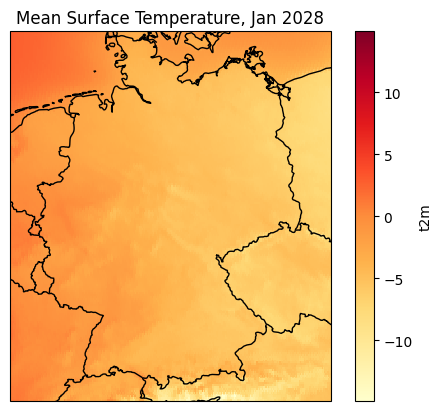

In [8]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cf

ax = plt.axes(projection=ccrs.Mercator())
t2m_germany_area_selection_monthly_mean.plot(ax=ax,transform=ccrs.PlateCarree(),cmap="YlOrRd",vmax=None)  
plt.title("Mean Surface Temperature, Jan 2028")
ax.coastlines()
ax.add_feature(cf.BORDERS)
plt.show()